## **Detecting Financial Crimes and Money Laundering**
In today’s world, banks have become well integrated into the technological era. This significant shift created an easy way of securing and monitoring money. Conversely, the transition provided a gateway for cyber criminals to target account holders of any bank. There are many transgressions that fall under financial crimes, however this project will focus on *Money Laundering*, which is defined by the federal government as the willingness to engage in illegal activity, which provides monetary value, and disguises assets as legal sources of income (U.S. Treasury, n.d.). The primary objective of this research is *“How can we accurately detect fraudulent activity in regards to money laundering?”* Due to the nature of the crime, it poses great challenges in detection given that the 'numbers' always align. As a result, it is most important to take into consideration deterministic columns and the relationship between each transaction. The importance of creating a model that effectively classifies laundering charges allows for easier investigation given that in current times, there are more than million transactions that happen over one week of time, and organized crime groups use this to their advantage to hide their illegal activity. 

#### **History**

Prior to uncovering such a prevalent issue, it is important to understand the origins of this type of financial crime. To launder money was to find some means of concealing one’s source of income and disguising it as something legal (FCA 2025). In doing so, this allowed illegal activity to happen under government regimes, and made it almost impossible to catch. The most notable timeframe in which money laundering played a big role in the history of the United States, was during the Prohibition era (FCA 2025). During this timeframe, the use of drinking alcoholic beverages was protested by mainly religious organizations as a way to revitalize the ‘ill parts’ of society (Britannica 2025). There is still uncertainty as to why alcohol was believed to resolve such societal issues, but what is known is that congress banned the consumption of alcohol. 

This consequently led to the most elaborate organized crime schemes in the United States, where mobsters distributed alcohol under the table. Concurrently, these small groups formed gangs hiring lawyers and accountants to hide their illegal activity (Roos, n.d.). This being the start of how money laundering integrated in the U.S. today. The amount of income from these organized groups funded hotels, casinos, and ultimately the black market (Roos, n.d.). In current times, this level of financial crime no longer exists given the changes within society and technological advancement. Although, attempts are still being made and now have become much more sophisticated to investigate. 

#### **Data**
The data being used in this research comes from the open source website [Kaggle](https://www.kaggle.com/). Within this site, there were several suitable datasets, however, the one chosen for this project was created by Erik Altman, [IBM Transactions for Anti Money Laundering (AML)](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml). He had created a virtual world reflective of the society and its entities (Altman 2021). The idea of this synthetic data is to simulate the different possibilities of money laundering, while also being able to confidently code the true successes of transactional fraud. Without any modifications to the dataset, there are no null values, making this dataset perfect for studying. As an important note, this dataset is in British English and this is reflective when exploring the dataset in the *Data Exploration.ipynb*.

In [1]:
import pandas as pd
import numpy as np

accounts = pd.read_csv('Files_CSV/HI-Small_accounts.csv')
transactions = pd.read_csv('Files_CSV/HI-Small_Trans.csv')

#### *HI-Small_accounts.csv*
Contains a total of 518,581 rows, which are representative of all the accounts utilized in the simulated transactions data. Since the simulation is reflective of society, this dataset also has 501 banks. Each bank has any number of accounts utilized under their bank, as well as any number of branching banks with the same name. However, the *HI-Small_accounts.csv* does encrypt each bank entity itself with a specialized number to distinguish it from other branching bank entities. In doing this, it does lead to a significant number of null values when splitting the banks from their specialized number. In contrast, this does not affect the dataset in any way, as it is a column there for assessing the relationships of each feature. Lastly, the data also contains the account type, also known as the reasoning for the existence of such an account. There are only 6 types: *Sole Proprietorship*, *Corporation*, *Partnership*, *Country*, *Individual*, and *Direct*.

In [2]:
# Split Columns
accounts[['Bank Name (2)', 'Bank Name (3)']] = accounts['Bank Name'].str.split('#', n=1, expand=True)

print(f'Total Rows/Accounts: {len(accounts)}')
print(f'Total Banks: {len(accounts['Bank Name (2)'].drop_duplicates())}')

Total Rows/Accounts: 518581
Total Banks: 501


#### *HI-Small_Trans.csv*
This dataset consists of all the transactions in a simulated world of 18 days. It has 5,078,345 total transactions, which is a mixture of all accounts from the *HI-Small_accounts.csv*. In terms of fraud detection, *Is Laundering* is the column at hand for testing. It is a boolean variable coded as True (1) or False (0). From this data, there is a total of 5,177 fraudulent transactions, this being about 0.1% of the total data. In light of this, it creates challenges of optimizing predictive modeling. Nevertheless, these datasets are highly reflective of how ingrained and difficult catching money laundering schemes are.

In [3]:
transactions.rename(columns={'Account': 'Acc. Orig.', 'Account.1': 'Acc. End'}, inplace=True)
count_ML = len(transactions[transactions['Is Laundering'] == 1])
count_Trans = len(transactions)

print(f'Total Rows: {count_Trans}')
print(f'Total Laundering: {count_ML}')
print(f'Percent of Laundering: {(count_ML/count_Trans)*100:.1f}%')

Total Rows: 5078345
Total Laundering: 5177
Percent of Laundering: 0.1%


#### **Initializing Datasets**

In order to properly implement the findings in *Dataset Exploration.ipynb*, the two CSV files will be merged on the receiving payments. This is due to the nature of the crime, as money laundering gets caught based on where the money ends. This also means all columns not necessary to apply in the final version will be dropped immediately to reduce computation processing power. Afterwards, all columns will be converted to their respective data types. Lastly, two datasets will be utilized, one for identifying all fraudulent accounts and unique banks. This dataframe is reflective of the one leveraged in the page analyzing the data. The second dataset is a copy of the merged files, this is to preserve all original data.

In [7]:
# Merge on Receiving Banks/Accounts
end_merge = pd.merge(transactions, accounts, left_on='Acc. End', right_on='Account Number', how='left')
end_df = end_merge.drop(['Timestamp', 'Acc. Orig.', 'Payment Currency', 
                      'Amount Paid', 'Amount Received', 'Account Number', 'Bank Name (3)', 
                      'Entity Name', 'Entity ID'], axis=1)

# Standardization
col_to_int = ['Bank ID', 'Is Laundering']
end_df[col_to_int] = end_df[col_to_int].astype(int)

# Laundering True & New Data
isFraud = end_df[end_df['Is Laundering'] == 1]
new_data = end_df.copy()

#### **Feature Engineering**

As stated prior, in depth analysis of which features will be included are in the *Dataset Exploration* file. The features encompassed are *Is ACH*, *Bank Diff*, *Sus. Acc.*, *Sus. Bank*, and *Sus. Corp.*. All columns will be created as boolean variables, except for identifying suspicious corporations. Due to there being a wide range of the number of transactions per corporation, this column will be mapped as four choices. Each represents different signifying parts of the boxplot and the absence of laundering attacks. In this way, corporations can be taken into account with different weights.

In [8]:
# Frequency of Payment Formats
new_data['Is ACH'] = end_df['Payment Format'] == 'ACH'

# 'To/From Bank' Difference
new_data['Bank Diff'] = end_df['To Bank'] != end_df['From Bank']

# Suspicious Accounts
list_sus_acc = isFraud['Acc. End'].drop_duplicates().tolist()
new_data['Sus. Acc.'] = end_df['Acc. End'].isin(list_sus_acc)

# Suspicious To Banks IDs
list_sus_banks = isFraud['Bank ID'].drop_duplicates().tolist()
new_data['Sus. Bank'] = end_df['Bank ID'].isin(list_sus_banks)

# Suspicious Corporations
sus_corps = isFraud.groupby('Bank Name (2)')['Bank Name (2)'].value_counts()
sus_corps_df = sus_corps.to_frame()
temp_merge = pd.merge(end_df, sus_corps_df, on='Bank Name (2)', how='left')
conditions = [
    (temp_merge['count'].isna()) | (temp_merge['count'] == 0),
    (temp_merge['count'] > 0) & (temp_merge['count'] <= 5),
    (temp_merge['count'] > 5) & (temp_merge['count'] <= 12),
    (temp_merge['count'] > 12)
]
choices = [0, 1, 2, 3]
new_data['Sus. Corp.'] = np.select(conditions, choices, default=np.nan)
new_data['Sus. Corp.'] = new_data['Sus. Corp.'].astype(int) 

# Drop Uneccessary Columns
col_drop = ['Acc. End', 'From Bank', 'To Bank', 'Receiving Currency', 'Payment Format', 'Bank Name', 'Bank ID', 'Bank Name (2)']
model_data = new_data.drop(columns=col_drop, axis=1)
model_data

,Is Laundering,Is ACH,Bank Diff,Sus. Acc.,Sus. Bank,Sus. Corp.
0,0,False,False,False,True,3
1,0,False,True,False,True,3
2,0,False,False,False,False,3
3,0,False,False,True,True,3
4,0,False,False,False,True,3
...,...,...,...,...,...,...
5078353,0,False,True,False,False,3
5078354,0,False,True,False,False,3
5078355,0,False,True,False,False,3
5078356,0,False,False,False,False,3


## **Random Forest Modeling**

This type of classification modeling was chosen for its capabilities in classification and high accuracy in a dataset with a significant amount of variance. At the same time, from the feature exploration, it is unsurprising that certain features in the model data aren’t as strong predictors, which is generally best handled by random forest modeling because of its ability to estimate how strong a feature is. This is critical when assessing transaction amounts and involved corporations. Considering the offense's characteristics, money laundering is as little as $1.00 and as much as thousands of dollars. In terms of corporations, banks are utilized either unsuspectingly or in association with such crimes causing there to be an enormous range of fraudulent transaction counts. The methods organized crime groups employ to disguise fraudulent transactions must maintain consistency with regular ones. Since there are millions of transactions made within one week, criminals will leverage that volume of traffic by laundering money over days to remain undetected. Thus, *Random Forest Modeling* is the best fit for detecting fraudulent activities.

*Random Forest Modeling* utilizes two concepts which prevents it from being a singular, overfitting tree. These are bagging and feature randomness. Bagging is the slang term for bootstrap aggregating. It consists of creating several datasets using the existing data, but randomly selects certain features for each created dataset. This feature randomness causes there to be a potential for one feature to appear across multiple datasets. Random Forest relies on its ability to lower variance, due to there being several random trees, making this model great for datasets that have a lot of variance in classification. It also contains more or less averaging where it looks at the majority vote of all the trees. I believe the averaging allows for people to see the accuracy of prediction.

In this model, there are several cons to this methodology, the most important for this project is the computational power. Since there are two different randomness factors, a significant amount of testing needs to be implemented to decide the parameter specifics. These parameters include the number of trees, the depth of each tree, and the number of features that should be incorporated in each tree. Another important con is interpretability of the random forest modeling, as this research cannot outline each tree and which factors are most significant to making the model successful. This is the result of why randomness works well, but also makes it harder to comprehend. Alongside single tree classification, there is a possibility of overfitting, however, the chances of this happening is lowered due to there being several trees created to prevent such an occurrence.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint 

X = model_data.drop('Is Laundering', axis=1)
y = model_data['Is Laundering']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_dist = {
    'n_estimators': randint(50, 100), 
    'max_depth': [10, 20, 30, None], 
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'class_weight': ['balanced', 'balanced_subsample', None] 
}
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=25,       
    cv=3,            
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1 
)
random_search.fit(X_train, y_train) 
best_model = random_search.best_estimator_
print("\nBest Parameters Found:")
print(random_search.best_params_)

# 6. Make predictions on the test set using the optimized model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] # Use probabilities for AUC

print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, y_pred))

# Note: You can also calculate the final ROC AUC score on the test set
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test Set ROC AUC Score: {test_auc:.4f}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best Parameters Found:
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 71}

Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1521886
           1       0.09      1.00      0.16      1622

    accuracy                           0.99   1523508
   macro avg       0.54      0.99      0.58   1523508
weighted avg       1.00      0.99      0.99   1523508

Test Set ROC AUC Score: 0.9982


**Classification Report**: Prior to running the model, a hyperparameter test was done to optimize random forest. It was found that the number of trees needed for the best results is 71. The classification report shows an increase of 0.05 in precision from the first attempt. On the other hand, the recall has significantly improved from 0.04 to 1, meaning that this model has successfully detected all fraudulent transactions. These results signify great improvement in fraud detection. However, the model runs into issues of too many false positives, which is demonstrated in the confusion matrix.

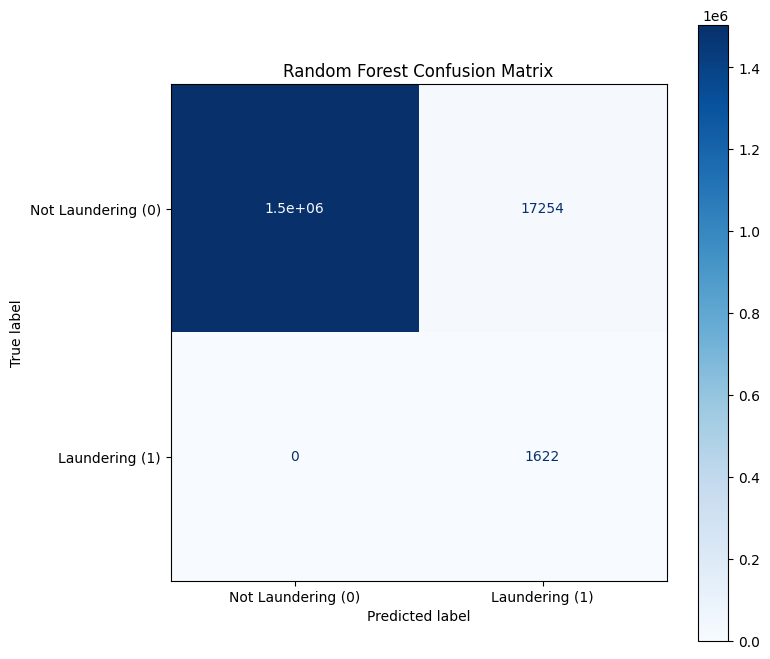

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
class_names = ['Not Laundering (0)', 'Laundering (1)']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax) 
plt.title('Random Forest Confusion Matrix')
plt.show()

**Confusion Matrix**: This chart provides an in-depth understanding of the model's categorization. When looking at this diagram as a whole, there are no false positives, again meaning that the model did not miss a fraudulent charge. However, running into the tradeoff of there being a significant number of false positives (FP=17,254), which is approximately 1.13% of the testing dataset. Even though it is a little more than one percent of the transactions that were classified as false positives, it is still a significant amount when looking at the count. Fortunately, the model showed no false negatives when detecting money laundering.

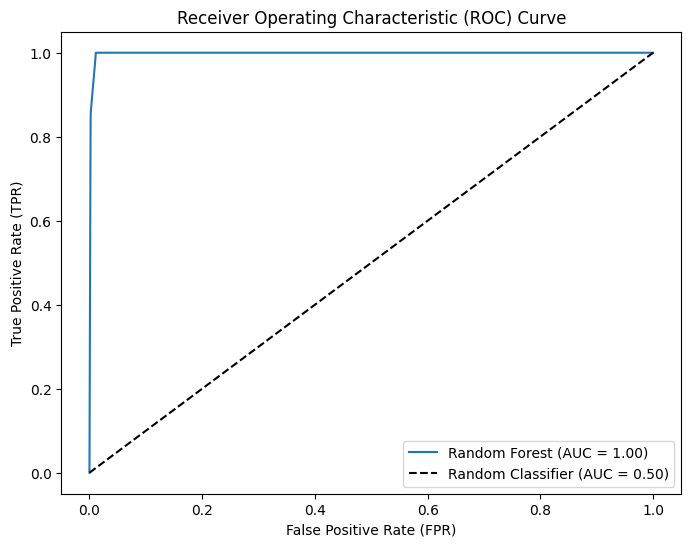

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**ROC Curve & AUC**: The ROC curve represents the true positive rate over the false positive rate over the false positive rate, which measures the model’s performance. Signifying how well it did at classifying the data. In comparative terms, feature engineering had increased the curve up to an almost perfect score of 0.9982, and the first attempt at only about 0.59. The AUC score measures the area underneath the ROC curve. It similarly evaluates the performance of the model, except it quantifies how perfect a model is compared to random guessing. The closer the AUC score is to one, the more predictive a model is.

## **Ending Results**
Overall, the results from the classification report, confusion matrix, and ROC curve have increased significantly since the first attempt, which contained no feature engineering. This significant increase has determined that it is possible to utilize machine learning in money laundering detection, but with specialized feature engineering. As it is important to consider that the first attempt was unsuccessful due the row data having too much variance. Another factor to consider is that deploying a machine model has its limitations to interpretation as the results still show about 1.13% of false positives, and while that may not seem like much, the count itself is over 17,000+ transactions to assess. Random forest modeling would not be utilized as the only deciding factor in what is and is not a money laundering attempt, as it is equally important to have human analysis and investigations of how a particular person or entity was able to receive such income.

## **Impact**

As seen in the results, this predictive modeling was successful, at the cost of a high number of false positives. Fortunately, the percentage of false positives from true positives is less than 2%. From how money laundering is committed and the intricacies involved, it may not be possible to build a model that truly captures every intentionally fraudulent transaction without having a high false positive rate. After all, money laundering is one of the few organized crimes which involves groups of people and entities. They follow particular steps to deter suspicious activity and often utilize several banking corporations or banking locations without their knowledge. These crimes are often kept well under the radar because of the significant number of parties involved and the businesses these criminals disguise illegal income as. 

In terms of positive impacts, this study can be used for future research to assist in the relational aspects of money laundering transactions. As seen in the feature discovery, only a minimal percentage of banks and account numbers are utilized for fraudulent activity. This suggests that entities involved may even be bankers coinciding with criminal activity, leading to a more extensive investigation. Concurrently, this project looks at potential features provided, while a fake dataset gives an in-depth analysis of why such columns are important in fraud detection, allowing for more informed modeling for future researchers. 

## **References**

Altman, E. (2021). IBM transactions for anti-money laundering (AML) [Data set]. Kaggle. https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml

Britannica. (2024). Prohibition: United States history [1920–1933]. Encyclopedia Britannica. https://www.britannica.com/event/Prohibition-United-States-history-1920-1933

Financial Crime Academy. (n.d.). The history of money laundering. https://financialcrimeacademy.org/the-history-of-money-laundering-2/

GeeksforGeeks. (2025). What is Feature Engineering? GeeksforGeeks. Retrieved from https://www.geeksforgeeks.org/machine-learning/what-is-feature-engineering/

HISTORY. (2023, June 7). How Prohibition fueled the rise of the American mob. HISTORY. https://www.history.com/articles/prohibition-organized-crime-al-capone

U.S. Department of the Treasury. (2021, November 29). Money laundering. https://home.treasury.gov/policy-issues/terrorism-and-illicit-finance/money-laundering